# Load a trained model and assess performance

In [1]:
import sys
import os
import numpy as np
np.random.seed(42)

import tensorflow as tf
from tensorflow import keras
from bumps.initpop import lhs_init
import pandas as pd

import json
import refl1d
from refl1d.names import *

from matplotlib import pyplot as plt
import matplotlib.lines as mlines
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')


In [2]:
# Directory in which the code sits
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'ml-nr-two-layers')

# Data directory
data_dir = os.path.join(git_dir, 'data')

In [3]:
# Path to our test data
haynes = os.path.join(data_dir, 'haynes_off_off_v2.dat')

In [4]:
sys.path.append(git_dir)

import reflectivity_model_haynes
import importlib
importlib.reload(reflectivity_model_haynes)

<module 'reflectivity_model_haynes' from '/Users/m2d/git/ml-nr-two-layers/reflectivity_model_haynes.py'>

In [5]:
# Load some data to define the q axis
data_off = np.loadtxt(os.path.join(data_dir, "haynes_off_off_v2.dat")).T
q_ref = data_off[0]

In [6]:
m = reflectivity_model_haynes.ReflectivityModels(q=q_ref)

model = reflectivity_model_haynes.load_model('haynes', os.path.join(data_dir, 'training_data'))

dict_keys(['loss', 'val_loss'])
Number of epochs: 20


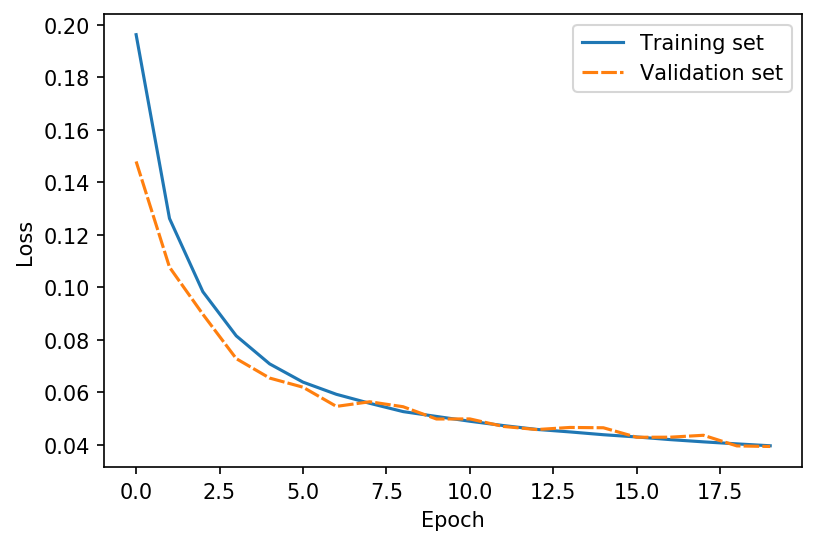

In [7]:
with open(os.path.join(data_dir, "training_data", "haynes_history.json"), 'r') as fd:
    history = json.load(fd)
    print(history.keys())
    
print("Number of epochs: %g" % len(history['loss']))

linestyle = (0, (5, 1))

fig = plt.figure(dpi=150)
plt.plot(np.arange(len(history['loss'])), history['loss'], label='Training set')
plt.plot(np.arange(len(history['val_loss'])), history['val_loss'], label='Validation set', linestyle=linestyle)

plt.gca().legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [8]:
%%time
n_train = 20000 # Used for straight results
n_train = 100000 # Used when adding statistical fluctuations.

m = reflectivity_model_haynes.ReflectivityModels(q=q_ref)
m.generate(n_train)

# To simulate a measurement, pass a relative uncertainty array.
# To use theory predictions without statistical fluctuations, pass errors=None.
errors = data_off[2]/data_off[1]
_test_pars, test_data = m.get_preprocessed_data(errors=errors)
test_pars = m.to_model_parameters(_test_pars)

_preds = model.predict(test_data)
preds = m.to_model_parameters(_preds)

print(len(test_data))


Computing reflectivity
100000
CPU times: user 38.3 s, sys: 685 ms, total: 38.9 s
Wall time: 35.6 s


In [9]:
for i, p in enumerate(m.parameters):
    print("%d %s %s" % (i, m.model_description['layers'][p['i']]['name'], p['par']))

0 substrate roughness
1 bulk sld
2 bulk thickness
3 bulk roughness
4 oxide sld
5 oxide thickness
6 oxide roughness


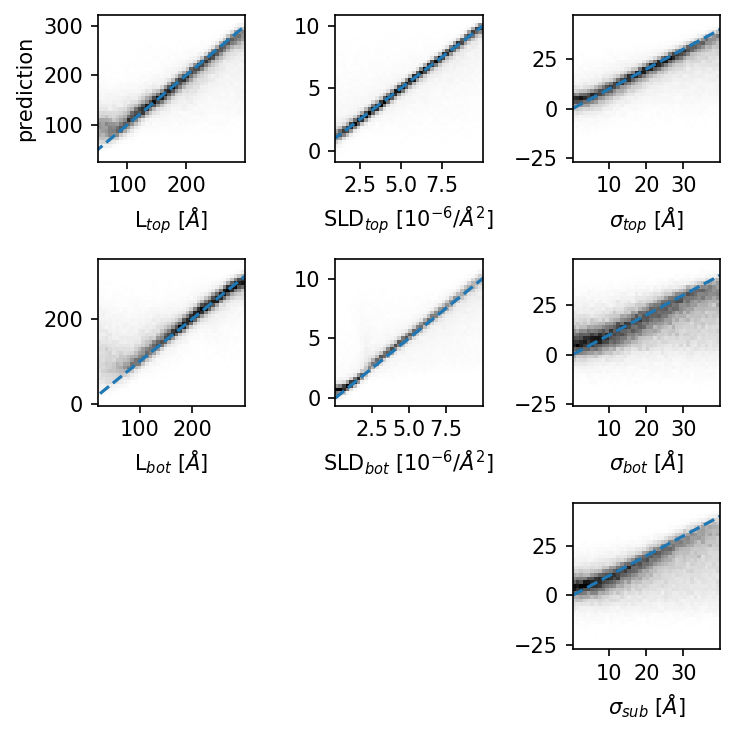

In [10]:
n_bins=40

fig, axs = plt.subplots(3, 3, sharey=False, tight_layout=True, dpi=150, figsize=(5,5))

ax = plt.subplot(3, 3, 1)
ax.hist2d(test_pars[:,5], preds[:,5], bins=n_bins, cmap="Greys")
l = mlines.Line2D([0, 300], [0, 300], linestyle='--')
ax.add_line(l)
plt.ylabel('prediction')
plt.xlabel('L$_{top}$ [$\AA$]')

ax = plt.subplot(3, 3, 2)
ax.hist2d(test_pars[:,4], preds[:,4], bins=n_bins, cmap="Greys")
l = mlines.Line2D([0, 30], [0, 30], linestyle='--')
ax.add_line(l)
plt.xlabel('SLD$_{top}$ [$10^{-6}/\AA^2$]')

ax = plt.subplot(3, 3, 3)
ax.hist2d(test_pars[:,6], preds[:,6], bins=n_bins, cmap="Greys")
l = mlines.Line2D([0, 50], [0, 50], linestyle='--')
ax.add_line(l)
plt.xlabel('$\sigma_{top}$ [$\AA$]')

ax = plt.subplot(3, 3, 4)
ax.hist2d(test_pars[:,2], preds[:,2], bins=n_bins, cmap="Greys")
l = mlines.Line2D([0, 300], [0, 300], linestyle='--')
ax.add_line(l)
plt.xlabel('L$_{bot}$ [$\AA$]')

ax = plt.subplot(3, 3, 5)
ax.hist2d(test_pars[:,1], preds[:,1], bins=n_bins, cmap="Greys")
l = mlines.Line2D([0, 50], [0, 50], linestyle='--')
ax.add_line(l)
plt.xlabel('SLD$_{bot}$ [$10^{-6}/\AA^2$]')

ax = plt.subplot(3, 3, 6)
ax.hist2d(test_pars[:,3], preds[:,3], bins=n_bins, cmap="Greys")
l = mlines.Line2D([0, 50], [0, 50], linestyle='--')
ax.add_line(l)
plt.xlabel('$\sigma_{bot}$ [$\AA$]')


ax = plt.subplot(3,3,7)
ax.axis('off')

ax = plt.subplot(3,3,8)
ax.axis('off')

ax = plt.subplot(3,3,9)
ax.hist2d(test_pars[:,0], preds[:,0], bins=n_bins, cmap="Greys")
l = mlines.Line2D([0, 50], [0, 50], linestyle='--')
ax.add_line(l)
plt.xlabel('$\sigma_{sub}$ [$\AA$]')

print()

Text(0.5, 0, '$\\Delta\\sigma_{sub}$ / $\\sigma_{sub}$')

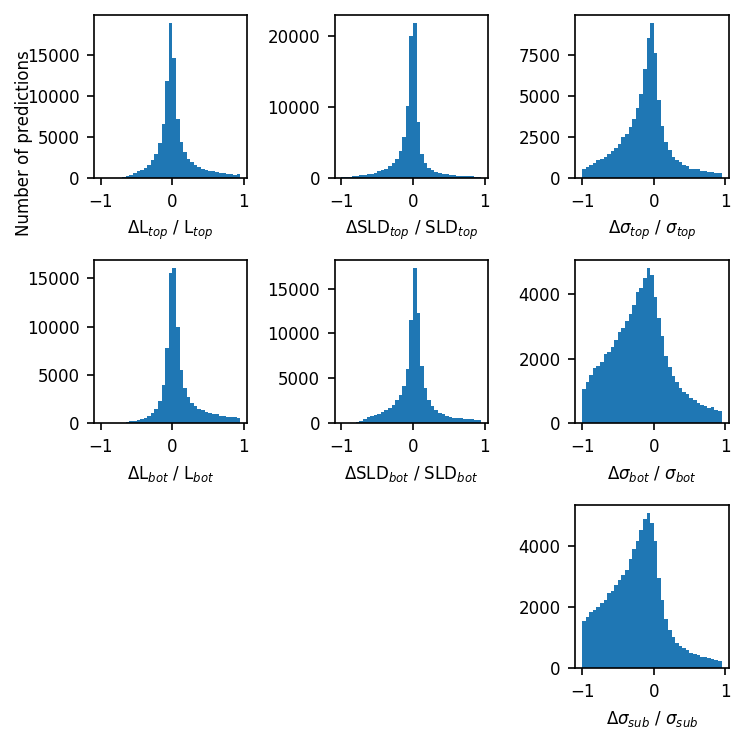

In [11]:
import matplotlib

font = {'size'   : 8}
matplotlib.rc('font', **font)

n_bins=40

fig, axs = plt.subplots(3, 3, sharey=False, tight_layout=True, dpi=150, figsize=(5,5))
plt.subplots_adjust(bottom=0.01)

ax = plt.subplot(3, 3, 1)
bins = np.arange(-1, 1.0,0.05)
ax.hist(-(test_pars[:,5]-preds[:,5])/test_pars[:,5], bins=bins)
#plt.ylabel('Counts')
plt.xlabel('$\Delta$L$_{top}$ / L$_{top}$')

ax.text(-2.2, -6600, 'Number of predictions', rotation=90, fontsize=8)

ax = plt.subplot(3, 3, 2)
ax.hist(-(test_pars[:,4]-preds[:,4])/test_pars[:,4], bins=bins)
plt.xlabel('$\Delta$SLD$_{top}$ / SLD$_{top}$')

ax = plt.subplot(3, 3, 3)
ax.hist(-(test_pars[:,6]-preds[:,6])/test_pars[:,6], bins=bins)
plt.xlabel('$\Delta\sigma_{top}$ / $\sigma_{top}$')

ax = plt.subplot(3, 3, 4)
ax.hist(-(test_pars[:,2]-preds[:,2])/test_pars[:,2], bins=bins)
plt.xlabel('$\Delta$L$_{bot}$ / L$_{bot}$')

ax = plt.subplot(3, 3, 5)
ax.hist(-(test_pars[:,1]-preds[:,1])/test_pars[:,1], bins=bins)
plt.xlabel('$\Delta$SLD$_{bot}$ / SLD$_{bot}$')

ax = plt.subplot(3, 3, 6)
ax.hist(-(test_pars[:,3]-preds[:,3])/test_pars[:,3], bins=bins)
plt.xlabel('$\Delta\sigma_{bot}$ / $\sigma_{bot}$')

ax = plt.subplot(3,3,7)
ax.axis('off')

ax = plt.subplot(3,3,8)
ax.axis('off')

ax = plt.subplot(3,3,9)
ax.hist(-(test_pars[:,0]- preds[:,0])/test_pars[:,0], bins=bins)
plt.xlabel('$\Delta\sigma_{sub}$ / $\sigma_{sub}$')



Text(0.5, 0, '$\\Delta\\sigma_{sub}$ [$\\AA$]')

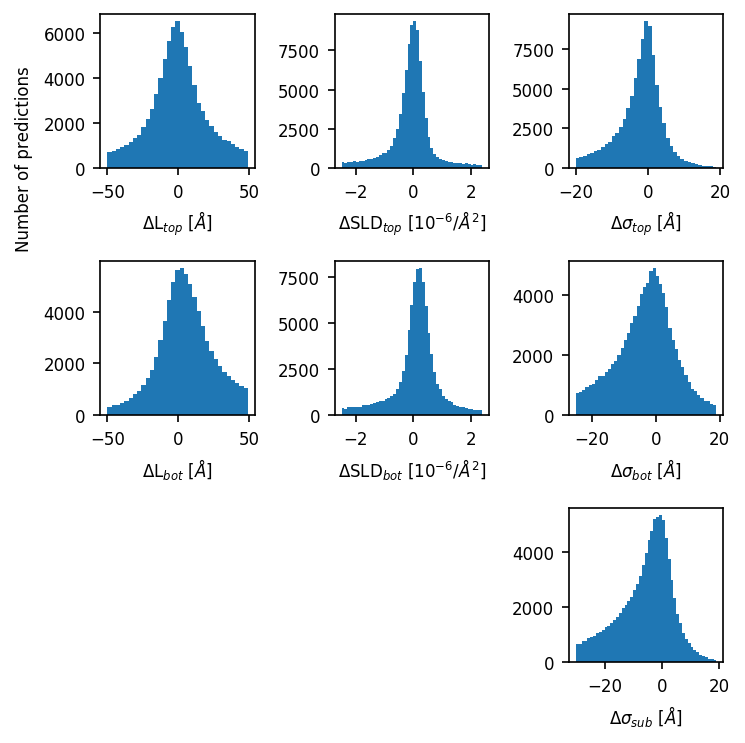

In [16]:
import matplotlib

font = {'size'   : 8}
matplotlib.rc('font', **font)

n_bins=40

fig, axs = plt.subplots(3, 3, sharey=False, tight_layout=True, dpi=150, figsize=(5,5))
plt.subplots_adjust(bottom=0.05)

ax = plt.subplot(3, 3, 1)
ax.hist(-(test_pars[:,5]-preds[:,5]), bins=np.arange(-50, 50, 3))
#plt.ylabel('Counts')
plt.xlabel('$\Delta$L$_{top}$ [$\AA$]')

ax.text(-115, -3500, 'Number of predictions', rotation=90, fontsize=8)

ax = plt.subplot(3, 3, 2)
ax.hist(-(test_pars[:,4]-preds[:,4]), bins=np.arange(-2.5, 2.5, 0.1))
plt.xlabel('$\Delta$SLD$_{top}$ [$10^{-6}/\AA^2$]')

ax = plt.subplot(3, 3, 3)
ax.hist(-(test_pars[:,6]-preds[:,6]), bins=np.arange(-20, 20, 1))
plt.xlabel('$\Delta\sigma_{top}$ [$\AA$]')

ax = plt.subplot(3, 3, 4)
ax.hist(-(test_pars[:,2]-preds[:,2]), bins=np.arange(-50, 50, 3))
plt.xlabel('$\Delta$L$_{bot}$ [$\AA$]')

ax = plt.subplot(3, 3, 5)
ax.hist(-(test_pars[:,1]-preds[:,1]), bins=np.arange(-2.5, 2.5, 0.1))
plt.xlabel('$\Delta$SLD$_{bot}$ [$10^{-6}/\AA^2$]')

ax = plt.subplot(3, 3, 6)
ax.hist(-(test_pars[:,3]-preds[:,3]), bins=np.arange(-25, 20, 1))
plt.xlabel('$\Delta\sigma_{bot}$ [$\AA$]')

ax = plt.subplot(3,3,7)
ax.axis('off')

ax = plt.subplot(3,3,8)
ax.axis('off')

ax = plt.subplot(3,3,9)
ax.hist(-(test_pars[:,0]- preds[:,0]), bins=np.arange(-30, 20, 1))
plt.xlabel('$\Delta\sigma_{sub}$ [$\AA$]')
